In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

# Load Dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/fraud/costsensitiveregression - costsensitiveregression.csv')

In [56]:
data.columns

Index(['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN', 'Status', 'FNC'],
      dtype='object')

In [59]:
X = data.iloc[:, 0:11].values
y = data.iloc[:, 11].values
fn_cost = data.iloc[:, 12].values

print("X shape:", X.shape)           # first 11 columns (features)
print("y shape:", y.shape)           # 12th column (target)
print("fn_cost shape:", fn_cost.shape)  # 13th column (cost)

print(data.describe())

X shape: (147636, 11)
y shape: (147636,)
fn_cost shape: (147636,)
            NotCount       YesCount           ATPM            PFD  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        7.722107      15.220908       0.253245       0.027062   
std         7.574278       7.596921       0.366280       0.335509   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000      10.000000       0.001084       0.000000   
50%         4.000000      19.000000       0.033354       0.000000   
75%        13.000000      21.000000       0.394372       0.000000   
max        23.000000      22.000000       1.000000      79.837480   

                 PFG            SFD            SFG             WP  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        0.050789       0.021648       0.071709       0.271927   
std         0.373370       0.298285       1.135755       2.432425   
min         0.000000       0.000000 

##### Split dataset

In [6]:
X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X, y, fn_cost, test_size=0.2, random_state=42)

#### Calculate Cost

In [7]:
def compute_cost_offset(
    y_true,
    y_prob,
    cFN_array,
    cFP=3,
    cTP=3,
    cTN=0,
    threshold=0.0
):

    y_pred = (y_prob >= threshold).astype(int) # Cast probability to 0 or 1

    cost_list = []
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 0: # Case False Negative
            cost_list.append(cFN_array[i])
        elif y_true[i] == 0 and y_pred[i] == 1: # Case False Positive
            cost_list.append(cFP)
        elif y_true[i] == 1 and y_pred[i] == 1: # Case True Positive
            cost_list.append(cTP)
        else: # Case True Negative
            cost_list.append(cTN)

    return np.mean(cost_list) # Average of all the cost


#### Evaluate Prediction - Train Cost, Test Cost, Accuracy

In [8]:
def evaluate_predictions(
    y_train,
    y_prob_train,
    cFN_train,
    y_test,
    y_prob_test,
    cFN_test,
    threshold
):
    # Calculate Training Cost
    train_cost = compute_cost_offset(
        y_true=y_train,
        y_prob=y_prob_train,
        cFN_array=cFN_train,
        threshold = threshold
    )

    # Calculate Test Cost
    test_cost = compute_cost_offset(
        y_true=y_test,
        y_prob=y_prob_test,
        cFN_array=cFN_test,
        threshold = threshold
    )

    total_cost = train_cost + test_cost

    y_pred_test = (y_prob_test >= threshold).astype(int)
    # Accuracy
    test_accuracy = (y_pred_test == y_test).mean()

    return train_cost, test_cost, total_cost, test_accuracy


In [9]:
def sigmoid(z): # sigmoid activation
    return 1 / (1 + np.exp(-z))

# Logistic Regression - Bahnsen

In [10]:
def cost_function(theta, X, y, fn_cost, lambda_):
    # Cost Function
    m = len(y)
    p = sigmoid(X.dot(theta))

    cost_positive = 3 * p + fn_cost * (1 - p) # when y == 1
    cost_negative = 3 * p # when y = 0

    cost_vec = y * cost_positive + (1 - y) * cost_negative
    base_cost = np.mean(cost_vec) # Average cost

    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2) # Regularisation Term

    return base_cost + reg_term

def gradient(theta, X, y, fn_cost, lambda_):
    # Gradient Calcuation
    m = len(y)
    p = sigmoid(X.dot(theta))

    # Cost
    intermediate_factor = y * (3 - fn_cost) + (1 - y) * 3
    factor =  intermediate_factor * p * (1 - p)

    grad = (X.T.dot(factor)) / m # gradient

    reg_term = (lambda_ / m) * np.concatenate([[0], theta[1:]]) # Regularisation Term

    return grad + reg_term

In [11]:
def predict_prob(X, theta):
    # probability output
    return sigmoid(X.dot(theta))

def predict(X, theta, threshold=0.5):
    # prediction
    return (predict_prob(X, theta) >= threshold).astype(int)

In [12]:
def add_intercept(X):  #bias
    m = X.shape[0]
    return np.concatenate([np.ones((m, 1)), X], axis=1)

In [13]:
def evaluate(theta, X_train, y_train, fn_train, X_test, y_test, fn_test, threshold):


    y_pred_train = predict(X_train, theta, threshold)
    y_pred_test = predict(X_test, theta, threshold)

    def compute_eval_cost(y_true, y_pred, fn_array):
        cost_list = []
        for i in range(len(y_true)):
            if y_true[i] == 1 and y_pred[i] == 0: # Case False Negative
                cost_list.append(fn_array[i])
            elif y_true[i] == 0 and y_pred[i] == 1: # Case False Positive
                cost_list.append(3)
            elif y_true[i] == 1 and y_pred[i] == 1: # Case True Positive
                cost_list.append(3)
            else:
                cost_list.append(0) # Case True Negative
        return np.mean(cost_list) # Average of all the cost

    train_cost = compute_eval_cost(y_train, y_pred_train, fn_train)
    test_cost = compute_eval_cost(y_test, y_pred_test, fn_test)

    total_cost = train_cost + test_cost
    accuracy = np.mean(y_pred_test == y_test)

    return train_cost, test_cost, total_cost, accuracy

In [14]:
num_iters = 2000
learning_rate = 0.01
lambda_ = 0.01

# List of thresholds from 0 to 1 to plot
thresholds = np.linspace(0, 1, 51)

train_costs_bn = []
test_costs_bn = []
acc_bn = []

In [15]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

##### Training

In [16]:
X_train_aug = add_intercept(X_train_std)
X_test_aug = add_intercept(X_test_std)


theta = np.zeros(X_train_aug.shape[1])


for i in range(num_iters):
    grad = gradient(theta, X_train_aug, y_train, fn_train, lambda_) # Calculate gradients
    theta -= learning_rate * grad
    if i % 100 == 0:
        train_cost_val = cost_function(theta, X_train_aug, y_train, fn_train, lambda_)
        print(f"Iteration {i:4d} | Training Cost: {train_cost_val:.4f}")

Iteration    0 | Training Cost: 7.8192
Iteration  100 | Training Cost: 2.7700
Iteration  200 | Training Cost: 2.5389
Iteration  300 | Training Cost: 2.4423
Iteration  400 | Training Cost: 2.3858
Iteration  500 | Training Cost: 2.3476
Iteration  600 | Training Cost: 2.3193
Iteration  700 | Training Cost: 2.2972
Iteration  800 | Training Cost: 2.2793
Iteration  900 | Training Cost: 2.2643
Iteration 1000 | Training Cost: 2.2516
Iteration 1100 | Training Cost: 2.2407
Iteration 1200 | Training Cost: 2.2310
Iteration 1300 | Training Cost: 2.2225
Iteration 1400 | Training Cost: 2.2148
Iteration 1500 | Training Cost: 2.2079
Iteration 1600 | Training Cost: 2.2016
Iteration 1700 | Training Cost: 2.1959
Iteration 1800 | Training Cost: 2.1906
Iteration 1900 | Training Cost: 2.1857


##### Evaluation

In [17]:
for thr in thresholds:
    tc, tsc, totc, acc = evaluate(theta, X_train_aug, y_train, fn_train, X_test_aug, y_test, fn_test, threshold=thr) # for all threshold
    train_costs_bn.append(tc)
    test_costs_bn.append(tsc)
    acc_bn.append(acc)

##### Plots

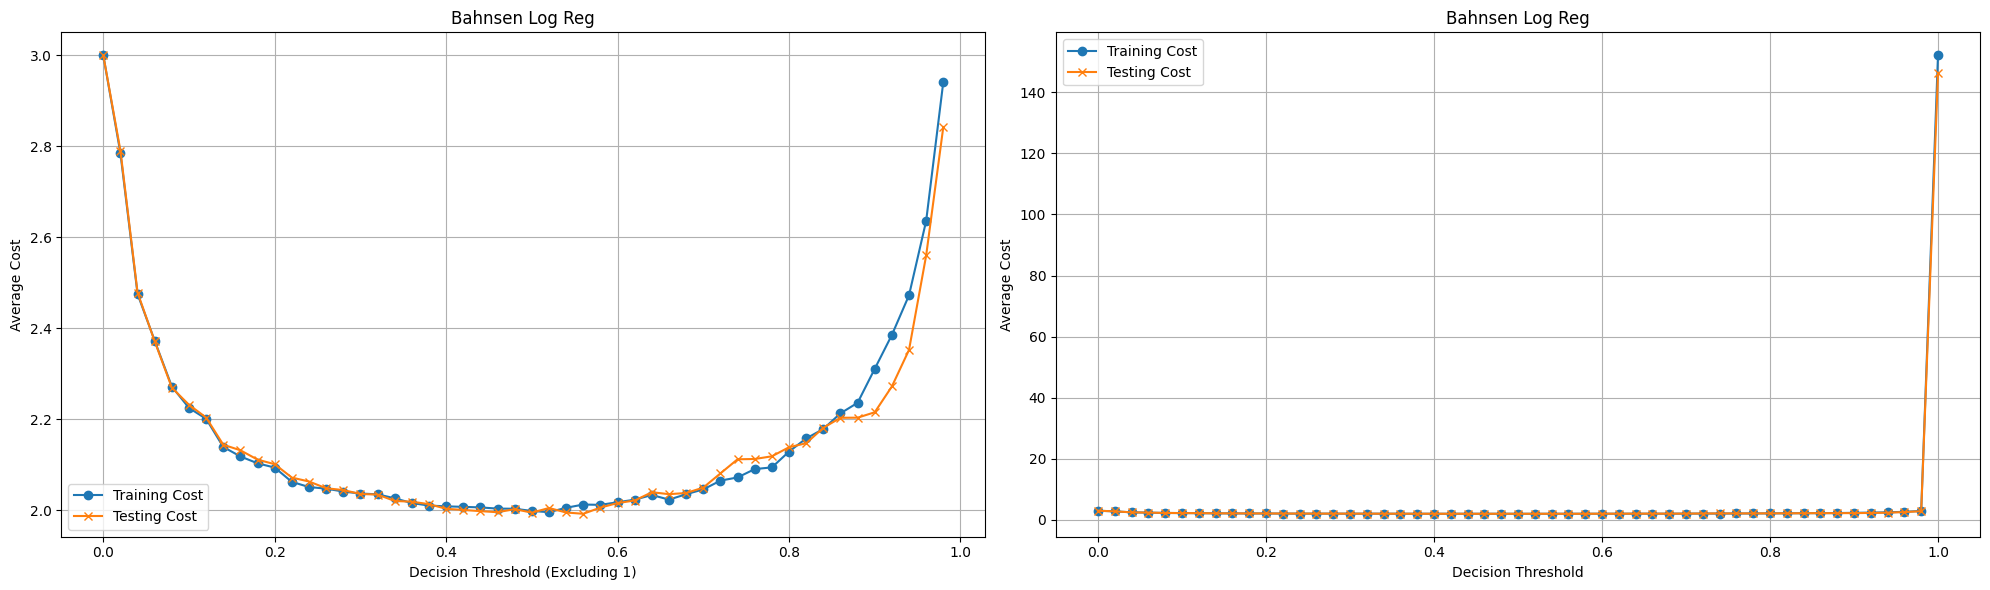

In [18]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(thresholds[:-1], train_costs_bn[:-1], marker='o', label="Training Cost")
plt.plot(thresholds[:-1], test_costs_bn[:-1], marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold (Excluding 1)")
plt.ylabel("Average Cost")
plt.title("Bahnsen Log Reg")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, train_costs_bn, marker='o', label="Training Cost")
plt.plot(thresholds, test_costs_bn, marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold")
plt.ylabel("Average Cost")
plt.title("Bahnsen Log Reg")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
for thr, traincost, testcost, acc in zip(thresholds, train_costs_bn, test_costs_bn, acc_bn):
    print(f"Threshold: {thr:.2f}, TrainCost: {traincost:.3f}, TestCost: {testcost:.3f} Accuracy: {acc:.3f}")


Threshold: 0.00, TrainCost: 3.000, TestCost: 3.000 Accuracy: 0.299
Threshold: 0.02, TrainCost: 2.785, TestCost: 2.790 Accuracy: 0.369
Threshold: 0.04, TrainCost: 2.475, TestCost: 2.479 Accuracy: 0.465
Threshold: 0.06, TrainCost: 2.373, TestCost: 2.371 Accuracy: 0.500
Threshold: 0.08, TrainCost: 2.272, TestCost: 2.270 Accuracy: 0.529
Threshold: 0.10, TrainCost: 2.225, TestCost: 2.232 Accuracy: 0.543
Threshold: 0.12, TrainCost: 2.201, TestCost: 2.204 Accuracy: 0.554
Threshold: 0.14, TrainCost: 2.139, TestCost: 2.144 Accuracy: 0.568
Threshold: 0.16, TrainCost: 2.119, TestCost: 2.132 Accuracy: 0.577
Threshold: 0.18, TrainCost: 2.104, TestCost: 2.112 Accuracy: 0.584
Threshold: 0.20, TrainCost: 2.094, TestCost: 2.102 Accuracy: 0.590
Threshold: 0.22, TrainCost: 2.063, TestCost: 2.072 Accuracy: 0.598
Threshold: 0.24, TrainCost: 2.051, TestCost: 2.064 Accuracy: 0.603
Threshold: 0.26, TrainCost: 2.048, TestCost: 2.049 Accuracy: 0.609
Threshold: 0.28, TrainCost: 2.041, TestCost: 2.045 Accuracy: 0

In [20]:
# Min Cost
min_index = test_costs_bn.index(min(test_costs_bn))

best_threshold = thresholds[min_index]
best_train_cost = train_costs_bn[min_index]
best_test_cost = test_costs_bn[min_index]
best_accuracy = acc_bn[min_index]

print(f"Best result (min test cost): Threshold: {best_threshold:.2f}, "
      f"TrainCost: {best_train_cost:.3f}, TestCost: {best_test_cost:.3f}, "
      f"Accuracy: {best_accuracy:.3f}")

Best result (min test cost): Threshold: 0.56, TrainCost: 2.013, TestCost: 1.993, Accuracy: 0.658


# Genetic Algorithm

In [21]:
import numpy as np
import random

random.seed(90000)
np.random.seed(90000)

In [22]:
def cost_function(theta, X, y, cFN, cTP=3, cFP=3, cTN=0):
    # Cost Function
    n_samples = X.shape[0]
    intercept = theta[0]
    coefs = theta[1:]

    z = intercept + np.dot(X, coefs)
    p = sigmoid(z)

    # When 1 p * 3 + (1 - p) * cFN
    # When 0 p * 3
    cost_array = np.where(y == 1, p * cTP + (1 - p) * cFN, p * cFP + (1 - p) * cTN)
    return np.mean(cost_array) # Averaged

In [23]:
def hybrid_selection(population, costs, k=3):  # Hybrid selection: Tournament + Roulette Wheel
    if np.random.rand() < 0.5:  # 50% chance to use tournament selection
        selected = np.random.choice(len(population), k, replace=False)
        best_idx = selected[np.argmin([costs[i] for i in selected])] # select minimum cost
        return population[best_idx]
    else:  # 50% chance to use roulette wheel selection
        probabilities = np.exp(-np.array(costs)) / np.sum(np.exp(-np.array(costs)))
        selected_idx = np.random.choice(len(population), p=probabilities) #randomly selecting
        return population[selected_idx]

In [24]:
def uniform_crossover(p1, p2): # Cross Over using mask
    mask = np.random.randint(0, 2, size=p1.shape, dtype=bool)
    child1 = np.where(mask, p1, p2)  #randomly inheriting from parents
    child2 = np.where(mask, p2, p1)
    return child1, child2

In [25]:
def adaptive_mutation(ind, mutation_rate, gen, n_generations, decay_factor=0.99):  # mutation rate with decay
    mutation_rate *= decay_factor  # Reduce mutation rate over generations
    if np.random.rand() < mutation_rate:
        mut_index = np.random.randint(len(ind))
        ind[mut_index] += np.random.normal(0, 0.1)
    return ind

In [26]:
def genetic_algorithm_minimize(
    X, y, cFN,
    pop_size=50,
    n_generations=200, # Number of generation
    mutation_rate=0.05,
    elite_fraction=0.05, # Retain 5% of the total with min cost
    patience=20,  # Early stopping after 20 generations with no improvement
    cTP=3, cFP=3, cTN=0
):
    n_features = X.shape[1]
    n_elite = max(1, int(elite_fraction * pop_size))
    population = [np.random.uniform(-1, 1, n_features + 1) for _ in range(pop_size)] # Create Population

    population.append(np.ones(n_features + 1)) # Add one entry with all features

    best_cost = float('inf')
    no_improve_count = 0 # Early stopping

    for gen in range(n_generations):
        costs = np.array([cost_function(ind, X, y, cFN, cTP, cFP, cTN) for ind in population]) # Compute Cost Fn
        sorted_indices = np.argsort(costs)
        population = [population[i] for i in sorted_indices]
        costs = costs[sorted_indices]

        if costs[0] < best_cost:
            best_cost = costs[0]
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience: # Early Stopping Computing
            print(f"Early stopping at generation {gen}")
            break

        new_population = population[:n_elite]  # Keep elites for retaining the best among the population

        # Add new entries to population
        while len(new_population) < pop_size:
            p1 = hybrid_selection(population, costs)
            p2 = hybrid_selection(population, costs)
            child1, child2 = uniform_crossover(p1, p2)

            new_population.append(adaptive_mutation(child1, mutation_rate, gen, n_generations))
            if len(new_population) < pop_size:
                new_population.append(adaptive_mutation(child2, mutation_rate, gen, n_generations))

        population = new_population

    # Return the best population
    return population[0]

##### Training

In [27]:
best_theta = genetic_algorithm_minimize(X_train, y_train, fn_train,
                                        pop_size=30,
                                        n_generations=50)

In [28]:
intercept_ga = best_theta[0]
coefs_ga     = best_theta[1:]
z_train_ga = intercept_ga + np.dot(X_train, coefs_ga)
z_test       = intercept_ga + np.dot(X_test, coefs_ga)
y_prob_train_ga = sigmoid(z_train_ga)
y_prob_test_ga = sigmoid(z_test)

##### Evaluation

In [29]:
train_costs_bn_ga =[]
test_costs_bn_ga = []
acc_bn_ga = []
for thr in thresholds:  #for all threshold
    train_cost_bn_ga, test_cost_bn_ga, total_cost_bn_ga, acc = evaluate_predictions(
      y_train, y_prob_train_ga, fn_train,
      y_test, y_prob_test_ga, fn_test, threshold = thr
    )
    train_costs_bn_ga.append(train_cost_bn_ga)
    test_costs_bn_ga.append(test_cost_bn_ga)
    acc_bn_ga.append(acc)

##### Plots

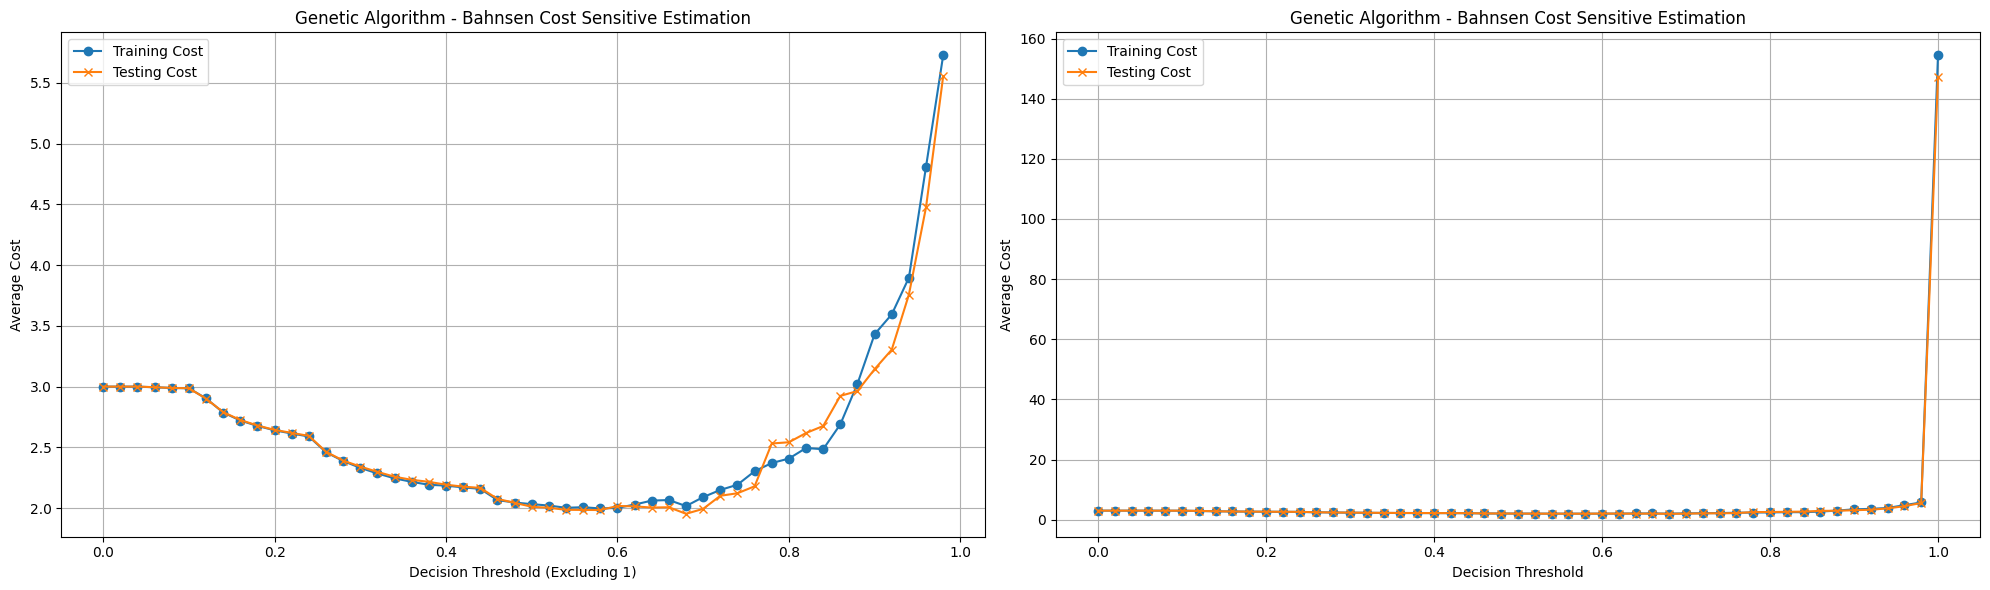

In [30]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(thresholds[:-1], train_costs_bn_ga[:-1], marker='o', label="Training Cost")
plt.plot(thresholds[:-1], test_costs_bn_ga[:-1], marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold (Excluding 1)")
plt.ylabel("Average Cost")
plt.title("Genetic Algorithm - Bahnsen Cost Sensitive Estimation")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, train_costs_bn_ga, marker='o', label="Training Cost")
plt.plot(thresholds, test_costs_bn_ga, marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold")
plt.ylabel("Average Cost")
plt.title("Genetic Algorithm - Bahnsen Cost Sensitive Estimation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
for thr, traincost, testcost, acc in zip(thresholds, train_costs_bn_ga, test_costs_bn_ga, acc_bn_ga):
    print(f"Threshold: {thr:.2f}, TrainCost: {traincost:.3f}, TestCost: {testcost:.3f} Accuracy: {acc:.3f}")

Threshold: 0.00, TrainCost: 3.000, TestCost: 3.000 Accuracy: 0.299
Threshold: 0.02, TrainCost: 3.000, TestCost: 3.000 Accuracy: 0.299
Threshold: 0.04, TrainCost: 3.000, TestCost: 3.000 Accuracy: 0.299
Threshold: 0.06, TrainCost: 2.995, TestCost: 2.995 Accuracy: 0.300
Threshold: 0.08, TrainCost: 2.989, TestCost: 2.989 Accuracy: 0.302
Threshold: 0.10, TrainCost: 2.987, TestCost: 2.987 Accuracy: 0.303
Threshold: 0.12, TrainCost: 2.903, TestCost: 2.901 Accuracy: 0.332
Threshold: 0.14, TrainCost: 2.787, TestCost: 2.790 Accuracy: 0.369
Threshold: 0.16, TrainCost: 2.721, TestCost: 2.725 Accuracy: 0.390
Threshold: 0.18, TrainCost: 2.676, TestCost: 2.680 Accuracy: 0.405
Threshold: 0.20, TrainCost: 2.640, TestCost: 2.644 Accuracy: 0.418
Threshold: 0.22, TrainCost: 2.614, TestCost: 2.619 Accuracy: 0.428
Threshold: 0.24, TrainCost: 2.589, TestCost: 2.594 Accuracy: 0.436
Threshold: 0.26, TrainCost: 2.460, TestCost: 2.464 Accuracy: 0.477
Threshold: 0.28, TrainCost: 2.387, TestCost: 2.391 Accuracy: 0

In [32]:
# Min Cost
min_index = test_costs_bn_ga.index(min(test_costs_bn_ga))

best_threshold = thresholds[min_index]
best_train_cost = train_costs_bn_ga[min_index]
best_test_cost = test_costs_bn_ga[min_index]
best_accuracy = acc_bn_ga[min_index]

print(f"Best result (min test cost): Threshold: {best_threshold:.2f}, "
      f"TrainCost: {best_train_cost:.3f}, TestCost: {best_test_cost:.3f}, "
      f"Accuracy: {best_accuracy:.3f}")

Best result (min test cost): Threshold: 0.68, TrainCost: 2.017, TestCost: 1.953, Accuracy: 0.706


# Logistic Regression - manual

In [33]:
def cost_function(theta, X, y, lambda_=0.0):
    m = len(y)
    h = sigmoid(X.dot(theta))

    # Add a small constant to avoid log(0)
    # Log loss
    cost = -np.mean(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15))

    # Regularization term (excluding the intercept theta[0])
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
    return cost + reg_term

# gradient of the logistic regression cost function
def gradient(theta, X, y, lambda_=0.0):
    m = len(y)
    h = sigmoid(X.dot(theta))
    error = h - y
    grad = (X.T.dot(error)) / m

    reg_term = (lambda_ / m) * np.concatenate([[0], theta[1:]])
    return grad + reg_term

In [34]:
def evaluate(theta, X, y, fn_array, threshold=0.5):
    y_pred = predict(X, theta, threshold)

    def cost_function(theta, X, y, y_pred, fn_array, lambda_=0.0):
      m = len(y)
      h = (sigmoid(X.dot(theta)) > threshold).astype(int)

      # Add a small constant to avoid log(0)
      # Log loss
      cost_list = []
      for i in range(m):
          if y[i] == 1 and y_pred[i] == 0:
              cost_list.append(fn_array[i])
          elif y[i] == 0 and y_pred[i] == 1:
              cost_list.append(3)
          elif y[i] == 1 and y_pred[i] == 1:
              cost_list.append(3)
          else:
              cost_list.append(0)
      base_cost = np.mean(cost_list)
      # Regularization term (excluding the intercept theta[0])
      reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
      return base_cost + reg_term

    cost = cost_function(theta, X, y, y_pred, fn_array)
    accuracy = np.mean(y_pred == y)
    return cost, accuracy

In [35]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_aug = add_intercept(X_train_std)
X_test_aug = add_intercept(X_test_std)

theta = np.zeros(X_train_aug.shape[1])

In [36]:
num_iters = 2000
learning_rate = 0.01
lambda_ = 0.01  # regularization strength

# List of thresholds from 0 to 1 to plot
thresholds = np.linspace(0, 1, 51)

train_costs_std = []
test_costs_std = []
acc_std = []

##### Train

In [37]:
# Run gradient descent
for i in range(num_iters):
    grad = gradient(theta, X_train_aug, y_train, lambda_)
    theta -= learning_rate * grad
    if i % 100 == 0:
        current_cost = cost_function(theta, X_train_aug, y_train, lambda_)
        print(f"Iteration {i:4d} | Training Cost: {current_cost:.4f}")

Iteration    0 | Training Cost: 0.6903
Iteration  100 | Training Cost: 0.5072
Iteration  200 | Training Cost: 0.4280
Iteration  300 | Training Cost: 0.3872
Iteration  400 | Training Cost: 0.3635
Iteration  500 | Training Cost: 0.3484
Iteration  600 | Training Cost: 0.3384
Iteration  700 | Training Cost: 0.3313
Iteration  800 | Training Cost: 0.3262
Iteration  900 | Training Cost: 0.3223
Iteration 1000 | Training Cost: 0.3194
Iteration 1100 | Training Cost: 0.3172
Iteration 1200 | Training Cost: 0.3155
Iteration 1300 | Training Cost: 0.3141
Iteration 1400 | Training Cost: 0.3129
Iteration 1500 | Training Cost: 0.3120
Iteration 1600 | Training Cost: 0.3113
Iteration 1700 | Training Cost: 0.3107
Iteration 1800 | Training Cost: 0.3102
Iteration 1900 | Training Cost: 0.3098


##### Evaluation

In [38]:
thresholds = np.linspace(0, 1, 51)
train_costs_std = []
test_costs_std = []
acc_std = []

In [39]:
for thr in thresholds:
    train_cost, train_acc = evaluate(theta, X_train_aug, y_train,fn_train, threshold=thr)
    test_cost, test_acc = evaluate(theta, X_test_aug, y_test, fn_test, threshold=thr)
    train_costs_std.append(train_cost)
    test_costs_std.append(test_cost)
    acc_std.append(test_acc)

##### Plots

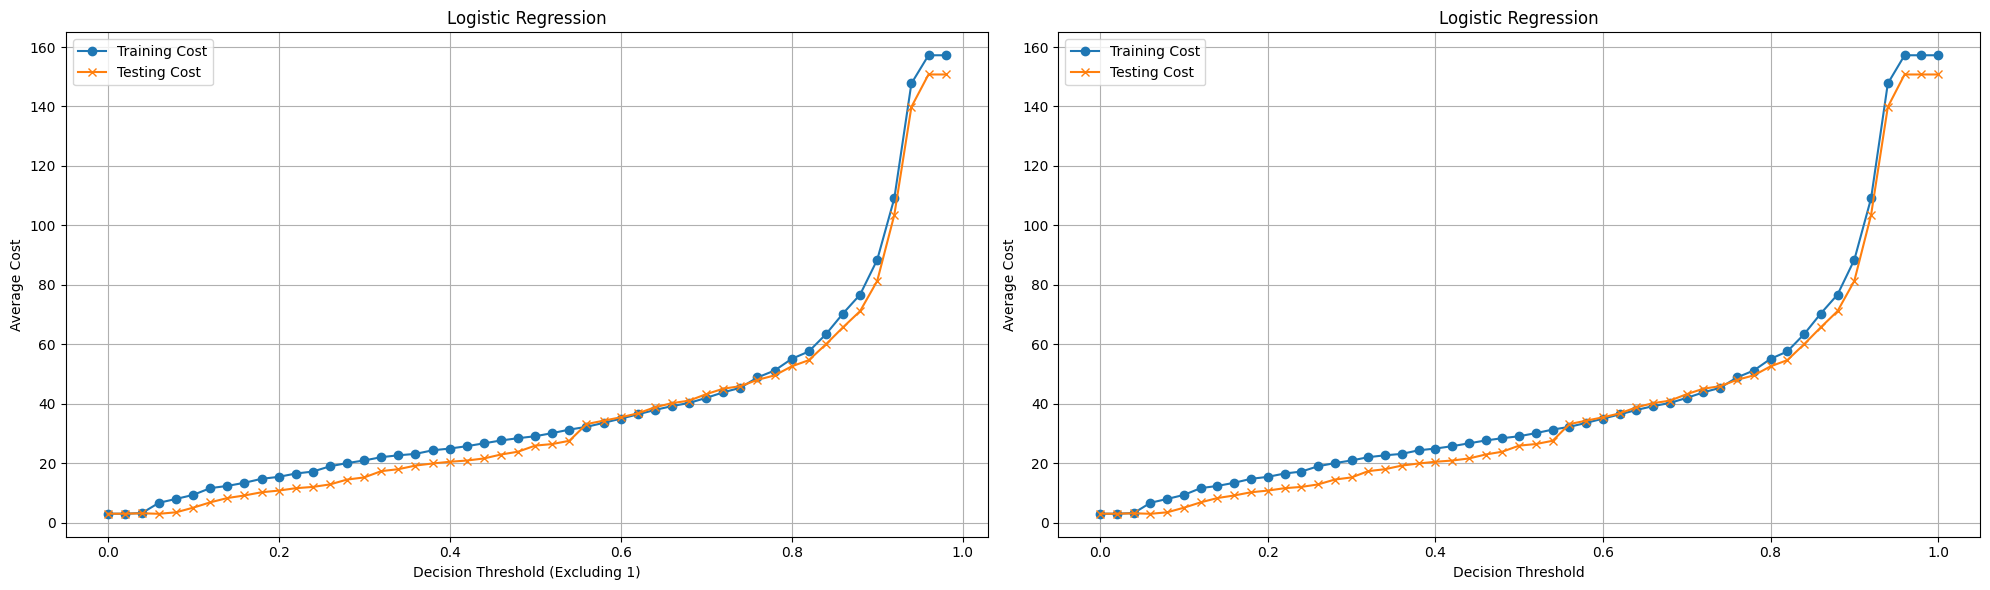

In [40]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(thresholds[:-1], train_costs_std[:-1], marker='o', label="Training Cost")
plt.plot(thresholds[:-1], test_costs_std[:-1], marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold (Excluding 1)")
plt.ylabel("Average Cost")
plt.title("Logistic Regression")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, train_costs_std, marker='o', label="Training Cost")
plt.plot(thresholds, test_costs_std, marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold")
plt.ylabel("Average Cost")
plt.title("Logistic Regression")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
for thr, traincost, testcost, acc in zip(thresholds, train_costs_std, test_costs_std, acc_std):
    print(f"Threshold: {thr:.2f}, TrainCost: {traincost:.3f},TestCost: {testcost:.3f} Accuracy: {acc:.3f}")

Threshold: 0.00, TrainCost: 3.000,TestCost: 3.000 Accuracy: 0.299
Threshold: 0.02, TrainCost: 2.996,TestCost: 2.995 Accuracy: 0.300
Threshold: 0.04, TrainCost: 3.209,TestCost: 3.142 Accuracy: 0.345
Threshold: 0.06, TrainCost: 6.670,TestCost: 2.968 Accuracy: 0.571
Threshold: 0.08, TrainCost: 7.971,TestCost: 3.470 Accuracy: 0.691
Threshold: 0.10, TrainCost: 9.322,TestCost: 5.026 Accuracy: 0.756
Threshold: 0.12, TrainCost: 11.605,TestCost: 6.823 Accuracy: 0.780
Threshold: 0.14, TrainCost: 12.344,TestCost: 8.271 Accuracy: 0.800
Threshold: 0.16, TrainCost: 13.404,TestCost: 9.136 Accuracy: 0.816
Threshold: 0.18, TrainCost: 14.735,TestCost: 10.213 Accuracy: 0.824
Threshold: 0.20, TrainCost: 15.391,TestCost: 10.773 Accuracy: 0.835
Threshold: 0.22, TrainCost: 16.515,TestCost: 11.581 Accuracy: 0.840
Threshold: 0.24, TrainCost: 17.171,TestCost: 12.010 Accuracy: 0.848
Threshold: 0.26, TrainCost: 18.952,TestCost: 12.851 Accuracy: 0.850
Threshold: 0.28, TrainCost: 20.030,TestCost: 14.483 Accuracy: 0

In [42]:
# Min loss
min_index = test_costs_std.index(min(test_costs_std))

best_threshold = thresholds[min_index]
best_train_cost = train_costs_std[min_index]
best_test_cost = test_costs_std[min_index]
best_accuracy = acc_bn_ga[min_index]

print(f"Best result (min test cost): Threshold: {best_threshold:.2f}, "
      f"TrainCost: {best_train_cost:.3f}, TestCost: {best_test_cost:.3f}, "
      f"Accuracy: {best_accuracy:.3f}")

Best result (min test cost): Threshold: 0.06, TrainCost: 6.670, TestCost: 2.968, Accuracy: 0.300


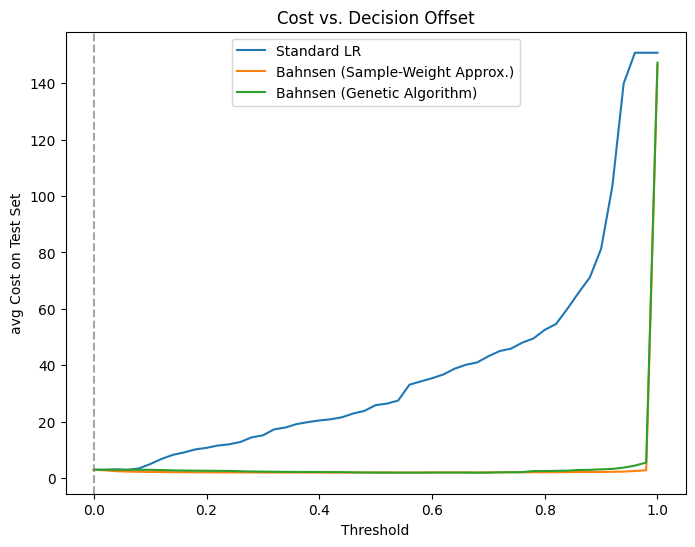

In [43]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, test_costs_std, label="Standard LR")
plt.plot(thresholds, test_costs_bn, label="Bahnsen (Sample-Weight Approx.)")
plt.plot(thresholds, test_costs_bn_ga, label="Bahnsen (Genetic Algorithm)")
# plt.yscale("log")
plt.axvline(x=0.0, color='gray', linestyle='--', alpha=0.7)  # offset=0 => threshold=0.5
plt.xlabel("Threshold")
plt.ylabel("avg Cost on Test Set")
plt.title("Cost vs. Decision Offset")
plt.legend()
plt.show()


# Bahnsen using Sklearn

sample_weight approach

##### Training

In [50]:
from sklearn.linear_model import LogisticRegression

sample_weights_train = np.where(y_train == 1, fn_train, 3.0) # Sample Weight initialisation

lr_bahnsen_sk = LogisticRegression(solver="lbfgs", max_iter=1000)
lr_bahnsen_sk.fit(X_train, y_train, sample_weight=sample_weights_train)

LogisticRegression(max_iter=1000)

##### Evaluation

In [51]:
# predict probability
y_prob_train_bn_sk = lr_bahnsen_sk.predict_proba(X_train)[:, 1]
y_prob_test_bn_sk = lr_bahnsen_sk.predict_proba(X_test)[:, 1]

In [52]:
train_costs_bn_sk = []
test_costs_bn_sk = []
acc_bn_sk = []
thresholds = np.linspace(0, 1, 51)
for thr in thresholds: # all thresh values from 0 to 1
    # compute loss for all threshold values
    train_cost_bn_sk, test_cost_bn_sk, total_cost_bn_sk, acc = evaluate_predictions(y_train, y_prob_train_bn_sk, fn_train, y_test, y_prob_test_bn_sk, fn_test, threshold = thr)
    train_costs_bn_sk.append(train_cost_bn_sk)
    test_costs_bn_sk.append(test_cost_bn_sk)
    acc_bn_sk.append(acc)

##### Plots

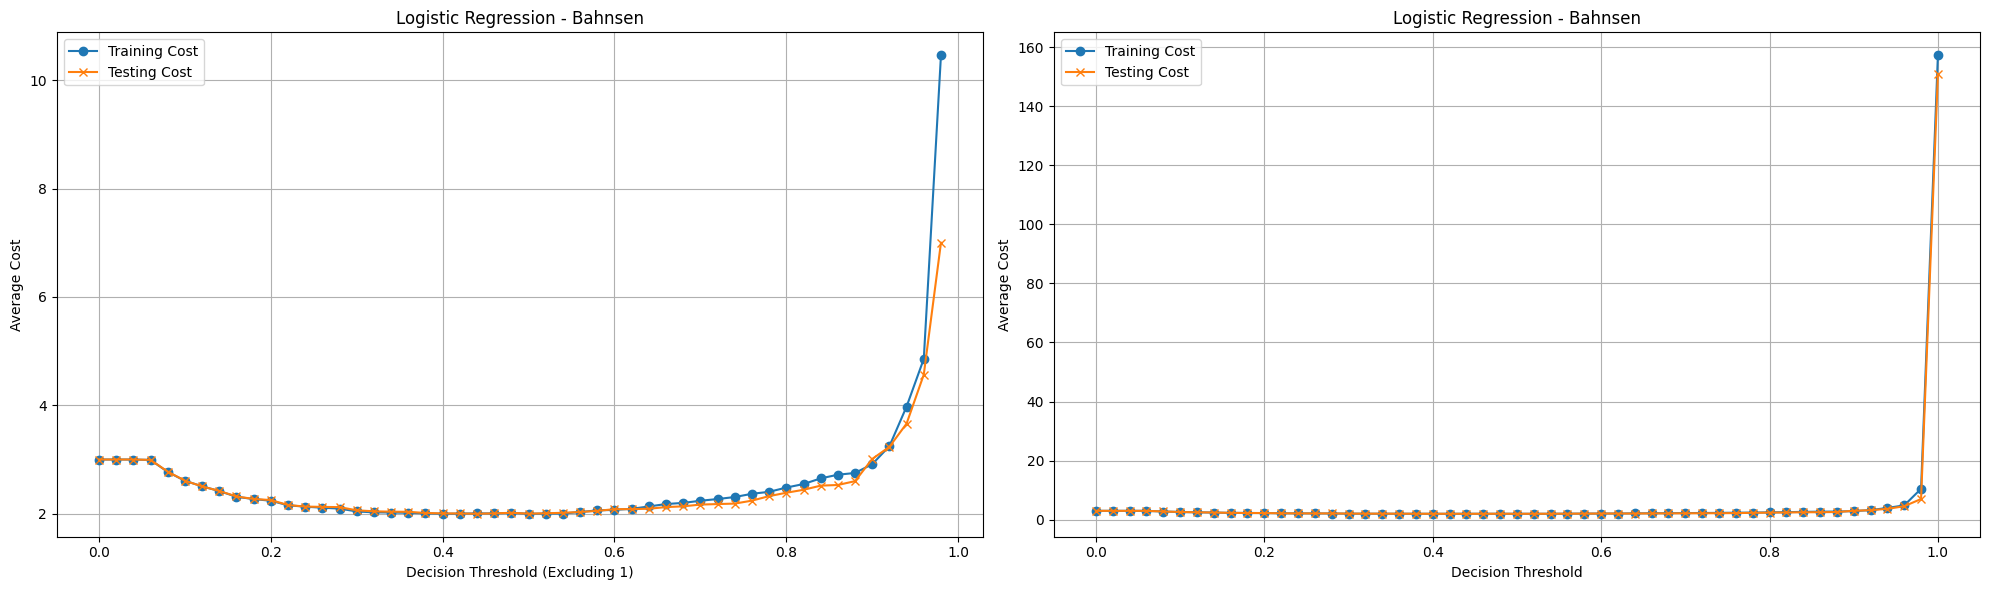

In [53]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(thresholds[:-1], train_costs_bn_sk[:-1], marker='o', label="Training Cost")
plt.plot(thresholds[:-1], test_costs_bn_sk[:-1], marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold (Excluding 1)")
plt.ylabel("Average Cost")
plt.title("Logistic Regression - Bahnsen")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, train_costs_bn_sk, marker='o', label="Training Cost")
plt.plot(thresholds, test_costs_bn_sk, marker='x', label="Testing Cost")
plt.xlabel("Decision Threshold")
plt.ylabel("Average Cost")
plt.title("Logistic Regression - Bahnsen")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
for thr, traincost, testcost, acc in zip(thresholds, train_costs_bn_sk, test_costs_bn_sk, acc_bn_sk):
    print(f"Threshold: {thr:.2f}, TrainCost: {traincost:.3f},TestCost: {testcost:.3f} Accuracy: {acc:.3f}")

Threshold: 0.00, TrainCost: 3.000,TestCost: 3.000 Accuracy: 0.299
Threshold: 0.02, TrainCost: 3.000,TestCost: 3.000 Accuracy: 0.299
Threshold: 0.04, TrainCost: 3.000,TestCost: 3.000 Accuracy: 0.299
Threshold: 0.06, TrainCost: 2.992,TestCost: 2.993 Accuracy: 0.301
Threshold: 0.08, TrainCost: 2.771,TestCost: 2.776 Accuracy: 0.373
Threshold: 0.10, TrainCost: 2.607,TestCost: 2.609 Accuracy: 0.427
Threshold: 0.12, TrainCost: 2.506,TestCost: 2.504 Accuracy: 0.461
Threshold: 0.14, TrainCost: 2.418,TestCost: 2.420 Accuracy: 0.486
Threshold: 0.16, TrainCost: 2.312,TestCost: 2.318 Accuracy: 0.518
Threshold: 0.18, TrainCost: 2.270,TestCost: 2.272 Accuracy: 0.533
Threshold: 0.20, TrainCost: 2.239,TestCost: 2.252 Accuracy: 0.544
Threshold: 0.22, TrainCost: 2.156,TestCost: 2.160 Accuracy: 0.569
Threshold: 0.24, TrainCost: 2.130,TestCost: 2.132 Accuracy: 0.580
Threshold: 0.26, TrainCost: 2.111,TestCost: 2.126 Accuracy: 0.590
Threshold: 0.28, TrainCost: 2.094,TestCost: 2.121 Accuracy: 0.597
Threshold:

In [55]:
# Min Cost
min_index = test_costs_bn_sk.index(min(test_costs_bn_sk))

best_threshold = thresholds[min_index]
best_train_cost = train_costs_bn_sk[min_index]
best_test_cost = test_costs_bn_sk[min_index]
best_accuracy = acc_bn_ga[min_index]

print(f"Best result (min test cost): Threshold: {best_threshold:.2f}, "
      f"TrainCost: {best_train_cost:.3f}, TestCost: {best_test_cost:.3f}, "
      f"Accuracy: {best_accuracy:.3f}")

Best result (min test cost): Threshold: 0.44, TrainCost: 2.006, TestCost: 2.000, Accuracy: 0.588
